# **PURE CRN model of TX-only models for MGapt**

In this notebook, we built and run sensitivity parameters on the proposed chemical reaction network transcription model for PURE protein synthesis. 

# Importing required packages and definitions

In [1]:
import biocrnpyler
from biocrnpyler import *
from biocrnpyler.component import Component
from biocrnpyler.chemical_reaction_network import Species, Reaction, ChemicalReactionNetwork
from biocrnpyler.mechanism import Mechanism
from biocrnpyler.reaction import Reaction
from biocrnpyler.species import Complex, Species, WeightedSpecies

import bioscrape

import numpy as np
import pandas as pd
import pylab as plt
from scipy import stats

import libsbml
import time
from typing import List, Union
import csv
import math
import matplotlib.pyplot as plt
import random 
import datetime

#Get directory
import os
directory = os.getcwd()

In [2]:
def create_custom_plot(title_text, x_max=8,y_max=2, yname='MGapt (μM)'):
    custom_plot = figure(
        toolbar_location='right',
        outline_line_color=None,
        min_border_right=10,
        height=400,
        width=400,
    )

    custom_plot.title.text = title_text
    custom_plot.xaxis.axis_label = 'Time (hours)'
    custom_plot.yaxis.axis_label = yname
    custom_plot.y_range = Range1d(0, y_max)
    custom_plot.x_range = Range1d(0, x_max)
    custom_plot.outline_line_color = None

    # custom_plot.yaxis
    custom_plot.ygrid.visible = False
    custom_plot.yaxis.axis_label_text_font_size = '15pt'
    custom_plot.yaxis.major_label_text_font_size = '15pt'
    custom_plot.yaxis.major_label_text_font = 'Work Sans'
    custom_plot.yaxis.axis_label_standoff = 15
    custom_plot.yaxis.axis_label_text_font_style = 'normal'

    # custom_plot.xaxis
    custom_plot.xgrid.visible = False
    custom_plot.xaxis.axis_label_text_font_size = '15pt'
    custom_plot.xaxis.major_label_text_font_size = '15pt'
    custom_plot.xaxis.major_label_text_font = 'Work Sans'
    custom_plot.xaxis.axis_label_standoff = 15
    custom_plot.xaxis.axis_label_text_font_style = 'normal'

    # custom_plot.title
    custom_plot.title.text_font_size = '18pt'
    custom_plot.title.align = 'left'
    custom_plot.title.offset = -70.0

    return custom_plot

## Bokeh

In [3]:
%matplotlib inline
import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()
from bokeh.themes import Theme

# Modules needed from Bokeh.
from bokeh.io import output_file, show
from bokeh.plotting import gridplot,figure
from bokeh.models import LinearAxis, Range1d

colors2 = bokeh.palettes.Colorblind[8]

try:
    import dnaplotlib as dpl
    dpl_enabled = True
except (ModuleNotFoundError,ImportError) as e:
    dpl_enabled = False
    
from bokeh.io import export_png

Loading BokehJS ...

## Definitions

In [4]:
#Definition to un-nest lists that will be created by models
def flatten(t):
    return [item for sublist in t for item in sublist]

# User defined transcribed unit

In [5]:
#User will copy the sequence bwteen end of promoter and start of terminator of DNA strain
#mGapt sequence
dna_seq='GGATCCCGACTGGCGAGAGCCAGGTAACGAATGGATCTCGAGCCTTAGGAGATCCGGCTGCTAACAAAGCCCGAAAGGAAGCTGAGTTGGCTGCTGCCACCGCTGAGCAATAA'
#mGapt_UTR1_deGFP 
# dna_seq= 'GGGATCCCGACTGGCGAGAGCCAGGTAACGAATGGATCCAATAATTTTGTTTAACTTTAAGAAGGAGATATACCATGGAGCTTTTCACTGGCGTTGTTCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCCTGACCTACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCGCCCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCTAACTCGAGCCTTAGGAGATCCGGCTGCTAACAAAGCCCGAAAGGAAGCTGAGTTG'

# PURE TX Model in BioCRNpyler
This model is based on the TX-TL from Tuza *et al.* [1] originally built for cell lysate protein expression. This section of code requires a DNA sequence input from the user. If transcription is not desired, an amino acid list can also serve as the input and this section can be omitted. The steps of the TX are split into 3 subsections: species and reactions based on nucleotide needed (1), generates complement sequence (2), and species and reactions of growing mRNA strand (3). 

<ol>
  <li>Non-nucleic acid Species and Reactions</li>
  <li>RNA sequence</li>
  <li> Addition of nucleotide and individual reactions for the desired DNA </li>
</ol>
 
### Citation:
[1] Zoltán A. Tuza, Dan Siegal-Gaskins, Jongmin Kim, and Gábor Szederkényi. Analysis-based parameter estimation of an *in vitro* transcription-translation system. In Eur. Control Conf. 2015, page 1554–1560, 2015. ([PNAS, 2015](https://ieeexplore.ieee.org/document/7330760))

In [6]:
p1 = bokeh.plotting.figure(toolbar_location='right',
    outline_line_color= None,
    min_border_right=10,
    height=400,
    width=600,)

p1.title.text = "A) Simulation Results of mRNA"
p1.xaxis.axis_label = 'Time (hours)'
p1.yaxis.axis_label = 'mRNA (μM)'
p1.outline_line_color=None

# p1.yaxis
p1.ygrid.visible = False
p1.yaxis.axis_label_text_font_size='15pt' 
p1.yaxis.major_label_text_font_size = '15pt'
p1.yaxis.major_label_text_font='Work Sans'
p1.yaxis.axis_label_standoff=15
p1.yaxis.axis_label_text_font_style='normal' 

# p1.xaxis
p1.xgrid.visible = False
p1.xaxis.axis_label_text_font_size='15pt' 
p1.xaxis.major_label_text_font_size = '15pt'
p1.xaxis.major_label_text_font='Work Sans'
p1.xaxis.axis_label_standoff=15
p1.xaxis.axis_label_text_font_style='normal' 

# p1.title
p1.title.text_font_size= '18pt' 
p1.title.align= 'left'
p1.title.offset=-65.0

## Non-nucleic acid Species and Reactions
<!--  -->
Creates all the species and reaction around the nucleotide sequences in the given transcribed regions, common protein and small molecules.

In [7]:
#Original Values
k_rnapbF1 = 6.1
k_rnapbF2 = 2.93
k_rnapbF3 =  7.82
k_start= 5.23
k_ntpbound= 1.47
k_ntpadd= 23.59
k_ntpdis=  948.25
k_term= 32.38

In [8]:
## Species
#Define species needed for TX 
T7RNAP = Species('T7RNAP') #ActivePolymerase
DNA = Species("DNA") 
mRNA_i=Species('mRNA_i') # mRNA intermediate species
mRNA_t=Species('mRNA_t') # mRNA intermediate species
MGapt=Species('MGapt') # mRNA species used to track total mRNA production
T7RNAP_bound = Species("T7RNAP_bound") 
T7RNAP_bound_GTP=Species('T7RNAP_bound_GTP')
T7RNAP_bound_GDP_PO4= Species('T7RNAP_bound_GDP_PO4')

#Nucleotide bases that are "active"
ATP=Species('ATP')
GTP=Species('GTP')
CTP=Species('CTP')
UTP=Species('UTP')

#Other small molecules
GDP=Species('GDP')
PPi=Species('PPi')
PO4=Species('PO4')

#Define placing all species in one array 
Species_general= [T7RNAP, DNA, mRNA_i, MGapt, mRNA_t,
                  ATP, GTP, CTP, UTP,PPi, PO4,                   
                  T7RNAP_bound_GTP, T7RNAP_bound, 
                  T7RNAP_bound_GDP_PO4, T7RNAP_bound_GTP,]

#Define Reactions needed for TX regardless of the sequence defined
RXN_general= [
    #Binding of RNAP and beginning of transcription
    Reaction.from_massaction([T7RNAP, DNA, GTP], [T7RNAP_bound_GTP], k_forward=k_rnapbF1),
    Reaction.from_massaction([T7RNAP_bound_GTP], [T7RNAP_bound_GDP_PO4], k_forward=k_rnapbF2),
    Reaction.from_massaction([T7RNAP_bound_GDP_PO4], [T7RNAP_bound,GDP, PO4], k_forward=k_rnapbF3),]

## Transcribing DNA sequence to mRNA sequence

Transcribed the DNA input into RNA nucleotides. Output is a list of the nucleotides used to make the mRNA. 

In [9]:
# Transcribed given DNA sequence into mRNA sequence
def getTranscript(dna):
    transcript = []
    for bp in dna:
        if bp == 'A':
            tx = ATP
        elif bp == 'T':
            tx =UTP
        elif bp == 'G':
            tx =GTP
        elif bp == 'C':
            tx =CTP
        else:
            print('Non-standard nucleotides')
            
        transcript.append(tx)

    return transcript

In [10]:
#Translating RNA sequence from DNA sequence
rna_seq = getTranscript(dna_seq)
# print(rna_seq)

## Addition of nucleotide and individual reactions for the desired DNA

Individually adds each nucleotide of the growing mRNA strand. 

In [11]:
#Start iternations to loop over mRNA sequence
nt_len = len(rna_seq)
mrna_length='0000'
rxn_list=[]
species_list=[]

for L in [l for l in range(len(rna_seq))]:
    ntp = rna_seq[L]
    mrna0 = mrna_length[:-len(str(L))]+str(L) #starting mRNA
    mrnaG = mrna_length[:-len(str(L+1))]+str(L+1) #Growing mRNA
    
    #Initiation of mRNA strand 
    if L == 0:       
        T7RNAP_bound_mRNAmrna0 = Species('T7RNAP_bound_mRNA'+mrna0)
        T7RNAP_bound_mRNAmrna0_ntp = Species('T7RNAP_bound_mRNA'+mrna0+'_'+ str(ntp))
        T7RNAP_bound_mRNAmrnaG_nmp_PPi = Species('T7RNAP_bound_mRNA'+mrnaG+'_PPi')
        T7RNAP_bound_mRNAmrnaG = Species('T7RNAP_bound_mRNA'+mrnaG)
        
        species= [T7RNAP_bound_mRNAmrna0, T7RNAP_bound_mRNAmrna0_ntp, T7RNAP_bound_mRNAmrnaG_nmp_PPi, T7RNAP_bound_mRNAmrnaG]
        
        rxns=[Reaction.from_massaction([T7RNAP_bound],[Species('T7RNAP_bound_mRNA'+mrna0)],k_forward=k_start), #can add DNA, DNA
              Reaction.from_massaction([Species('T7RNAP_bound_mRNA'+mrna0), ntp], [Species('T7RNAP_bound_mRNA'+mrna0+'_'+ str(ntp))], k_forward=k_ntpbound),
              Reaction.from_massaction([Species('T7RNAP_bound_mRNA'+mrna0+'_'+ str(ntp))],[Species('T7RNAP_bound_mRNA'+mrnaG+'_PPi')],k_forward=k_ntpadd),
              Reaction.from_massaction([Species('T7RNAP_bound_mRNA'+mrnaG+'_PPi')],[Species('T7RNAP_bound_mRNA'+mrnaG), PPi],k_forward=k_ntpdis),] 
     
    #Elongation of mRNA strand  
    elif L<nt_len-1:
        T7RNAP_bound_mRNAmrna0_ntp = Species('T7RNAP_bound_mRNA'+mrna0+'_'+ str(ntp))
        T7RNAP_bound_mRNAmrnaG_nmp_PPi = Species('T7RNAP_bound_mRNA'+mrnaG+'_PPi')
        T7RNAP_bound_mRNAmrnaG = Species('T7RNAP_bound_mRNA'+mrnaG)

        species= [T7RNAP_bound_mRNAmrna0_ntp, T7RNAP_bound_mRNAmrnaG_nmp_PPi, T7RNAP_bound_mRNAmrnaG]
            
        if L==38:
            rxns=[Reaction.from_massaction([Species('T7RNAP_bound_mRNA'+mrna0), ntp], [Species('T7RNAP_bound_mRNA'+mrna0+'_'+ str(ntp))], k_forward=k_ntpbound),
              Reaction.from_massaction([Species('T7RNAP_bound_mRNA'+mrna0+'_'+ str(ntp))],[Species('T7RNAP_bound_mRNA'+mrnaG+'_PPi')],k_forward=k_ntpadd),
              Reaction.from_massaction([Species('T7RNAP_bound_mRNA'+mrnaG+'_PPi')],[Species('T7RNAP_bound_mRNA'+mrnaG), PPi,MGapt],k_forward=k_ntpdis),] 
        else:
            rxns=[Reaction.from_massaction([Species('T7RNAP_bound_mRNA'+mrna0), ntp], [Species('T7RNAP_bound_mRNA'+mrna0+'_'+ str(ntp))], k_forward=k_ntpbound),
                  Reaction.from_massaction([Species('T7RNAP_bound_mRNA'+mrna0+'_'+ str(ntp))],[Species('T7RNAP_bound_mRNA'+mrnaG+'_PPi')],k_forward=k_ntpadd),
                  Reaction.from_massaction([Species('T7RNAP_bound_mRNA'+mrnaG+'_PPi')],[Species('T7RNAP_bound_mRNA'+mrnaG), PPi,],k_forward=k_ntpdis),] 
        
    #Termination of mRNA strand      
    else:
        T7RNAP_bound_mRNAmrna0_ntp = Species('T7RNAP_bound_mRNA'+mrna0+'_'+ str(ntp))
        T7RNAP_bound_mRNAmrnaG_nmp_PPi = Species('T7RNAP_bound_mRNA'+mrnaG+'_PPi')
        T7RNAP_bound_mRNAmrnaG = Species('T7RNAP_bound_mRNA'+mrnaG)
        
        species= [T7RNAP_bound_mRNAmrna0_ntp, T7RNAP_bound_mRNAmrnaG_nmp_PPi, T7RNAP_bound_mRNAmrnaG,]
                   
        rxns=[Reaction.from_massaction([Species('T7RNAP_bound_mRNA'+mrna0), ntp], [Species('T7RNAP_bound_mRNA'+mrna0+'_'+ str(ntp))], k_forward=k_ntpbound),
              Reaction.from_massaction([Species('T7RNAP_bound_mRNA'+mrna0+'_'+ str(ntp))],[Species('T7RNAP_bound_mRNA'+mrnaG+'_PPi')],k_forward=k_ntpadd),  
              Reaction.from_massaction([Species('T7RNAP_bound_mRNA'+mrnaG+'_PPi')],[Species('T7RNAP_bound_mRNA'+mrnaG), PPi],k_forward=k_ntpdis),
              Reaction.from_massaction([Species('T7RNAP_bound_mRNA'+mrnaG),],[T7RNAP, DNA, mRNA_i,mRNA_t],k_forward=k_term)]#
        
    #Appending each reaction and species to the one before       
    rxn_list.append(rxns)
    species_list.append(species)

#Flattening to th nested lists 
species_list = flatten(species_list)
rxn_list= flatten(rxn_list)

# Combining CRN_TX

In [12]:
#List of all species and reactions
All_species_TX = flatten([Species_general, species_list])
All_rxn_TX = flatten([RXN_general, rxn_list])

#IC for Transcription only reactions
initial_con={'T7RNAP':(1), 'DNA':(.005), 'ATP':(3750), 'GTP':(2500), 'CTP':(1250), 'UTP':(1250),'mRNA_i':0} #in uM

#Buliding the CRN_TX and saving as a SBML file
CRN_TX = ChemicalReactionNetwork(species = All_species_TX, reactions = All_rxn_TX)
filename='CRN_PURE_MGaptTXonly'
CRN_TX.write_sbml_file(filename+".xml")

len(CRN_TX.reactions),len(CRN_TX.species)
#MGapt_only:  (344, 355)

(344, 355)

## Update model

In [13]:
def update_model_local_to_global_params(filename):
    import libsbml
    # rename parameters in sbml file so that they have same ID
    sbml_doc = libsbml.readSBMLFromFile(filename) # load your old SBML file
    param_dict = {}
    sbml_model = sbml_doc.getModel()
    for rxn in sbml_model.getListOfReactions():
        kl = rxn.getKineticLaw()
        for param in kl.getListOfLocalParameters():
            param_dict[param.getValue()] = param.getId()
    added_params = []
    changelog = {}
    count = 0
    for p_val, p in param_dict.items():
        sbml_param = sbml_model.createParameter()
        if p in added_params:
            p_new = p+str(count)
            changelog[p_val] = p_new
            sbml_param.setId(p_new)
            added_params.append(p_new)
        else:
            sbml_param.setId(p)
            added_params.append(p)
        count += 1
        sbml_param.setValue(p_val)
        sbml_param.setConstant(False)

    for rxn in sbml_model.getListOfReactions():
        kl = rxn.getKineticLaw()
        for param in list(kl.getListOfLocalParameters()):
            if param.getValue() in changelog:
                # print('renaming {0} with {1}'.format(param.getId(), changelog[param.getValue()]))
                kl.setFormula(kl.getFormula().replace(param.getId(), changelog[param.getValue()]))
            kl.removeLocalParameter(param.getId())


    updated_filname = filename.split('.xml')[0] + '_updated.xml'

    libsbml.writeSBML(sbml_doc, updated_filname) # write your new SBML

In [14]:
update_model_local_to_global_params(filename+'.xml')

# Run sensitivity analysis

In [15]:
"""To run this file on HPC, simply run:
`sbatch sensitivity_analysis.sh`
"""
import numpy as np
import pandas as pd

from bioscrape.simulator import py_simulate_model, ModelCSimInterface, DeterministicSimulator
from bioscrape.inference import py_inference
from bioscrape.analysis import py_sensitivity_analysis

import matplotlib.pyplot as plt
from bioscrape.types import Model
import time
import pandas as pd
import warnings
import seaborn as sn

#IC for Transcription only reactions
initial_con={'T7RNAP':(1), 'DNA':(.005), 'ATP':(3750), 'GTP':(2500), 'CTP':(1250), 'UTP':(1250),'mRNA_i':0}
timepoints = np.linspace(0, 3*3600, 3*180)

m = Model(sbml_filename = filename+"_updated.xml")
m.set_species(initial_con)
ssm = py_sensitivity_analysis(model = m, timepoints = timepoints, normalize = True)


C:\Users\zoila\anaconda3\envs\python38\lib\site-packages\bioscrape\analysis.py:244: RuntimeWarning: invalid value encountered in divide
  SSM_normalized[:,j,i] = np.divide(SSM[:,j,i]*params_values[j], solutions[:,i])


In [16]:
SSM=np.around(ssm[:,:,m.get_species2index()["MGapt"]].T, decimals=3, out=None)

In [19]:
np.savetxt('Inferencing_MGapt/Sensitivity_CRN_PURE_MGaptTXonly.csv', SSM, delimiter=',')

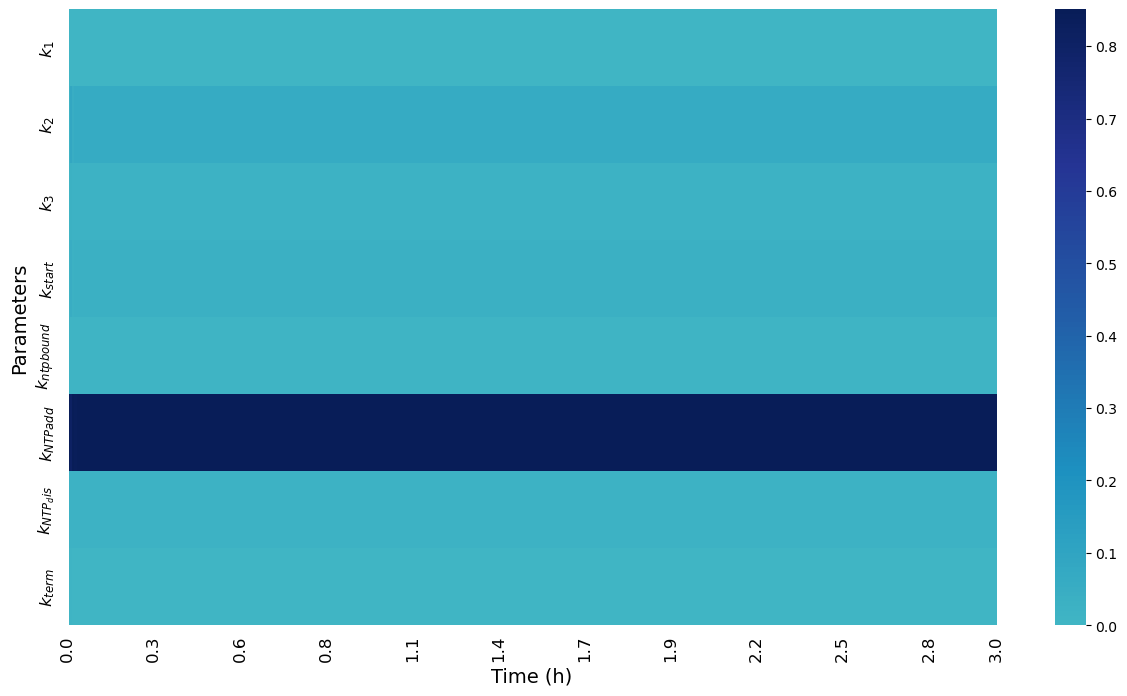

In [18]:
import seaborn as sn
figsize = (15,8)
fig, ax = plt.subplots(figsize=figsize)
index = 1
params_names_latex = ['$k_{1}$', '$k_{2}$', '$k_{3}$',
                      '$k_{start}$','$k_{ntpbound}$','$k_{NTPadd}$',
                      '$k_{NTP_dis}$','$k_{term}$',]
# Round the timepoints
rounded_timepoints = np.round(np.linspace(timepoints[0] / 3600, timepoints[-1] / 3600, len(timepoints),
                                           endpoint=True, dtype='float'), 1)

sn_ax = sn.heatmap(SSM, ax = ax, annot=False, cmap = 'YlGnBu',
                   xticklabels = rounded_timepoints, center=0,)

sn_ax.figure.axes[-1].xaxis.label.set_size(20)
ax = fig.axes
_ = plt.xlabel('Time (h)', fontsize = 14)
_ = plt.ylabel('Parameters', fontsize = 14)
_ = ax[0].tick_params(axis='x', which='major', labelsize=12, bottom = False)
_ = ax[0].tick_params(axis='y', which='major', labelsize=12, left = False)
_ = ax[0].set_yticklabels(params_names_latex)
every_nth =50
for n, label in enumerate(ax[0].xaxis.get_ticklabels()):
    if n == len(timepoints)-1:
        continue
    if n % every_nth != 0:
        label.set_visible(False)
_ = ax[1].tick_params(axis = 'x', labelsize = 18)
_ = plt.savefig('Figures/PURE_CRN_TX-sensitivity_MGapt.svg')
plt.show()

In [20]:
for x in range(len(params_names_latex)):
    print(params_names_latex[x], SSM[x,1:200].mean())

$k_{1}$ 0.0
$k_{2}$ 0.06018090452261306
$k_{3}$ 0.022939698492462312
$k_{start}$ 0.033924623115577895
$k_{ntpbound}$ 0.0073668341708542735
$k_{NTPadd}$ 0.8478391959798995
$k_{NTP_dis}$ 0.02099999999999999
$k_{term}$ 0.004999999999999999


### Most sensitive parameters
$k_{1}$ 0.0
$k_{2}$ 0.06018090452261306
$k_{3}$ 0.022939698492462312
$k_{start}$ 0.033924623115577895
$k_{ntpbound}$ 0.0073668341708542735
$k_{NTPadd}$ 0.8478391959798995
$k_{NTP_dis}$ 0.02099999999999999
$k_{term}$ 0.004999999999999999

# Computing environment

In [21]:
%load_ext watermark
%watermark -v -p bioscrape,bokeh,panel,jupyterlab,biocrnpyler

Python implementation: CPython
Python version       : 3.8.17
IPython version      : 8.12.2

bioscrape  : 1.2.1
bokeh      : 2.4.0
panel      : 0.13.1
jupyterlab : 3.6.5
biocrnpyler: 1.1.1

